In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("FoodcomRecipes").getOrCreate()

recipes_df = spark.read.option("header", True).csv(
    "hdfs:///user/jagadeesh/datasets/foodcom/recipes.csv"
)

print(recipes_df.columns)

['id', 'name', 'description', 'ingredients', 'ingredients_raw_str', 'serving_size', 'servings', 'steps', 'tags', 'search_terms']


In [35]:
recipes_df.show(5)

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+
|    id|                name|         description|         ingredients| ingredients_raw_str|        serving_size|            servings|               steps|                tags|        search_terms|    ingredients_list|num_ingredients|description_length|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+
| 96313|grilled garlic ch...|we love grits thi...|['water', 'grits'...|"[""4   cups    w...|""1   cup   uncoo...|""1   teaspoon   ...|""4   ounces   sh...|""1 -2   clove   ...|           minced ""|[water,  grits,  ...|              6|    

In [17]:
from pyspark.sql.functions import col, split, explode, trim, regexp_replace

recipes_df = recipes_df.na.drop()

tags_df = recipes_df.select("tags")

cleaned_tags_df = tags_df.withColumn(
    "tags",
    regexp_replace(col("tags"), r'[\[\]"\']', "")
)
cleaned_tags_df = cleaned_tags_df.withColumn("tag", explode(split(col("tags"), ",")))
cleaned_tags_df = cleaned_tags_df.withColumn("tag", trim(col("tag")))
cleaned_tags_df = cleaned_tags_df.filter(col("tag") != "")
cleaned_tags_df.groupBy("tag").count().orderBy(col("count").desc()).show(20, truncate=False)

cleaned_tags_df.write.mode("overwrite").option("header", True).csv(
    "hdfs:///user/jagadeesh/datasets/foodcom/cleaned_tags/"
)

+-----------------------+-----+
|tag                    |count|
+-----------------------+-----+
|chopped                |11104|
|minced                 |6831 |
|1/2  teaspoon    salt  |4864 |
|1   teaspoon    salt   |3420 |
|1                      |3408 |
|diced                  |3355 |
|finely chopped         |3168 |
|1       egg            |2933 |
|2       eggs           |2851 |
|1/4  teaspoon    salt  |2841 |
|sliced                 |2794 |
|2       garlic cloves  |2721 |
|softened               |2224 |
|1   teaspoon    vanilla|2142 |
|salt                   |2050 |
|divided                |1972 |
|melted                 |1965 |
|1       garlic clove   |1925 |
|crushed                |1720 |
|4                      |1657 |
+-----------------------+-----+
only showing top 20 rows


In [18]:
from pyspark.sql.functions import lower

cleaned_tags_df = cleaned_tags_df.withColumn("tag", lower(trim(col("tag"))))
cleaned_tags_df = cleaned_tags_df.dropDuplicates(["tag"])

In [19]:
recipes_df = recipes_df.dropna(subset=["name", "description", "ingredients"])

In [20]:
from pyspark.sql.functions import regexp_replace, lower, trim

text_columns = ["name", "description"]
for col_name in text_columns:
    recipes_df = recipes_df.withColumn(col_name, trim(lower(regexp_replace(col(col_name), r"[^a-zA-Z0-9\s]", ""))))

In [21]:
recipes_df = recipes_df.withColumn(
    "ingredients_list",
    split(regexp_replace(col("ingredients"), r"[\[\]'\"]", ""), ",")
)

In [22]:
from pyspark.sql.functions import size, length

recipes_df = recipes_df.withColumn("num_ingredients", size(col("ingredients_list")))
recipes_df = recipes_df.withColumn("description_length", length(col("description")))

recipes_df.select("name", "num_ingredients", "description_length").show(10, truncate=False)

+-------------------------------------+---------------+------------------+
|name                                 |num_ingredients|description_length|
+-------------------------------------+---------------+------------------+
|grilled garlic cheese grits          |6              |293               |
|simple shrimp and andouille jambalaya|13             |131               |
|crock pot italian zucchini           |9              |56                |
|beef stew with dried cherries        |14             |384               |
|hot sweet almond brittle             |8              |161               |
|retro chicken amp chips casserole    |11             |139               |
|asparagus  omelette wraps            |8              |272               |
|potatocrab chowder                   |13             |17                |
|sweet and simple sloppy joes         |7              |257               |
|golden chocolate chip muffins        |10             |22                |
+------------------------

In [23]:
from pyspark.sql.functions import explode, col

ingredients_df = recipes_df.select(explode(col("ingredients_list")).alias("ingredient"))

ingredients_df.groupBy("ingredient").count().orderBy(col("count").desc()).show(20, truncate=False)

[Stage 19:==============>                                          (3 + 9) / 12]

+------------------+------+
|ingredient        |count |
+------------------+------+
| salt             |166061|
| butter           |91871 |
| sugar            |89232 |
| onion            |69465 |
| eggs             |62135 |
| water            |61767 |
| olive oil        |51558 |
| garlic cloves    |47993 |
| milk             |47948 |
| flour            |43054 |
| pepper           |41812 |
| brown sugar      |34085 |
| baking powder    |33756 |
| egg              |32051 |
| garlic           |29005 |
| vanilla          |28848 |
| baking soda      |28121 |
| salt and pepper  |28027 |
| parmesan cheese  |27344 |
| all-purpose flour|26896 |
+------------------+------+
only showing top 20 rows


In [33]:
tags_df.groupBy("tags").count().orderBy(col("count").desc()).show(20)

[Stage 45:>                                                       (0 + 12) / 12]

+--------------------+-----+
|                tags|count|
+--------------------+-----+
|          chopped ""|10873|
|           minced ""| 6766|
|""1/2  teaspoon  ...| 4684|
|                   1| 3405|
|            diced ""| 3307|
|""1   teaspoon   ...| 3286|
|                  ""| 3245|
|   finely chopped ""| 3102|
|""1/4  teaspoon  ...| 2719|
|           sliced ""| 2685|
|""2       garlic ...| 2377|
|         softened ""| 2166|
|    ""2       eggs""| 2093|
|     ""1       egg""| 2068|
|          divided ""| 1931|
|""1   teaspoon   ...| 1930|
|           melted ""| 1860|
|          crushed ""| 1671|
|""1       garlic ...| 1666|
|                   4| 1656|
+--------------------+-----+
only showing top 20 rows


In [32]:
recipes_df.orderBy(col("num_ingredients")).select("name", "num_ingredients").show(5)

[Stage 44:>                                                       (0 + 12) / 12]

+--------------------+---------------+
|                name|num_ingredients|
+--------------------+---------------+
|very lowcarb flop...|              1|
|egg yolks caster ...|              1|
|paprikahuhn mit n...|              1|
|and when i asked ...|              1|
|white flour sugar...|              1|
+--------------------+---------------+
only showing top 5 rows


In [38]:
from pyspark.sql.functions import length

recipes_df = recipes_df.withColumn("description_length", length(col("description")))
recipes_df.orderBy(col("description_length").desc()).select("name", "description_length").show(5)
recipes_df.orderBy(col("description_length")).select("name", "description_length").show(5)

+--------------------+------------------+
|                name|description_length|
+--------------------+------------------+
|iron chef chinese...|              2823|
|sarasotas florida...|              2327|
|sommers slushy st...|              2303|
|the drunk chefs h...|              2209|
|may wine punch wi...|              2191|
+--------------------+------------------+
only showing top 5 rows


[Stage 55:==============================================>         (10 + 2) / 12]

+--------------------+------------------+
|                name|description_length|
+--------------------+------------------+
|arugula and ricot...|                 0|
|flour ground almo...|                 0|
|selfrising flour ...|                 0|
|green and yellow ...|                 0|
|napa cabbage carr...|                 0|
+--------------------+------------------+
only showing top 5 rows


In [39]:
from pyspark.sql.functions import split, size, col

recipes_df = recipes_df.withColumn("steps_list", split(col("steps"), ","))
recipes_df = recipes_df.withColumn("num_steps", size(col("steps_list")))
recipes_df.select("name", "num_steps").show(10, truncate=False)

recipes_df.orderBy(col("num_steps")).select("name", "num_steps").show(10, truncate=False)
recipes_df.orderBy(col("num_steps").desc()).select("name", "num_steps").show(10, truncate=False)

+-------------------------------------+---------+
|name                                 |num_steps|
+-------------------------------------+---------+
|grilled garlic cheese grits          |1        |
|simple shrimp and andouille jambalaya|1        |
|crock pot italian zucchini           |1        |
|beef stew with dried cherries        |1        |
|hot sweet almond brittle             |1        |
|retro chicken amp chips casserole    |1        |
|asparagus  omelette wraps            |1        |
|potatocrab chowder                   |1        |
|sweet and simple sloppy joes         |1        |
|golden chocolate chip muffins        |1        |
+-------------------------------------+---------+
only showing top 10 rows


+------------------------------------------------------------+---------+
|name                                                        |num_steps|
+------------------------------------------------------------+---------+
|lubys cafeteria italian chicken breast                      |1        |
|quick double tomato chicken with artichoke hearts and olives|1        |
|prizewinning coconut cake                                   |1        |
|peachglazed hot roast beef sandwiches                       |1        |
|smoked salmon salad                                         |1        |
|baked potato egg rolls 5fix                                 |1        |
|swedish almond macaroons                                    |1        |
|cottage cheese pancakes                                     |1        |
|corn cold water lemon juice sugar butter salt               |1        |
|1930s swiss steak                                           |1        |
+--------------------------------------------------

[Stage 58:>                                                       (0 + 12) / 12]

+---------------------------------------------------------------------------------------------------------------------------+---------+
|name                                                                                                                       |num_steps|
+---------------------------------------------------------------------------------------------------------------------------+---------+
|you roll them in a flour tortilla real mexicans use corn tortillas                                                         |41       |
|black forest torte schwarzwaelder kirschtorte gluten free                                                                  |37       |
|pecan halves rolo chocolates chocolate chips                                                                               |37       |
|exceptional vegetable beef soup awesome aroma exquisite taste                                                              |33       |
|a striped bass                                 

In [40]:
recipes_df.withColumn("complexity", col("num_ingredients")+col("num_steps"))\
          .orderBy(col("complexity").desc())\
          .select("name", "num_ingredients", "num_steps", "complexity").show(5, truncate=False)

[Stage 59:>                                                       (0 + 12) / 12]

+------------------------------------------------+---------------+---------+----------+
|name                                            |num_ingredients|num_steps|complexity|
+------------------------------------------------+---------------+---------+----------+
|fiambre                                         |50             |1        |51        |
|dhansak with brown rice                         |47             |1        |48        |
|land and sea white meat version of surf and turf|46             |1        |47        |
|my big fat greek meat amp pasta casserole       |45             |1        |46        |
|12minute gourmet gravy                          |45             |1        |46        |
+------------------------------------------------+---------------+---------+----------+
only showing top 5 rows


In [41]:
from pyspark.sql.functions import split, size, length, col, explode
import matplotlib.pyplot as plt
from wordcloud import WordCloud

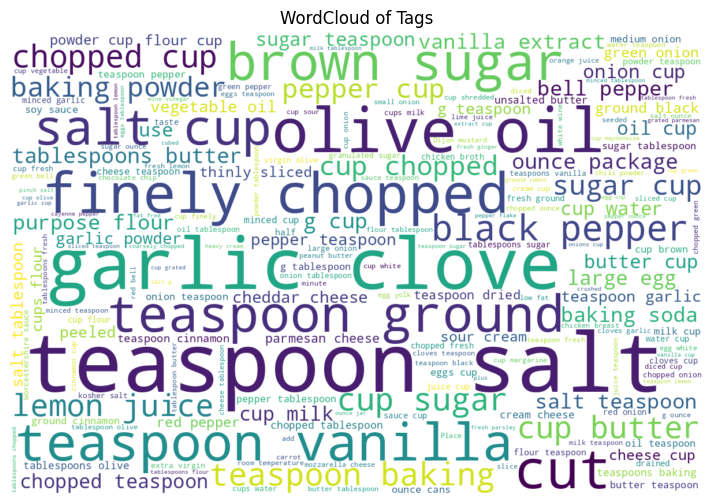

In [43]:
tags_text = " ".join(
    recipes_df.select(explode(split(col("tags"), ",")).alias("tag"))
              .na.drop()
              .rdd.map(lambda r: r["tag"].strip())
              .collect()
)

tag_wc = WordCloud(width=1200, height=800, background_color='white').generate(tags_text)
plt.figure(figsize=(10,6))
plt.imshow(tag_wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Tags")
plt.show()

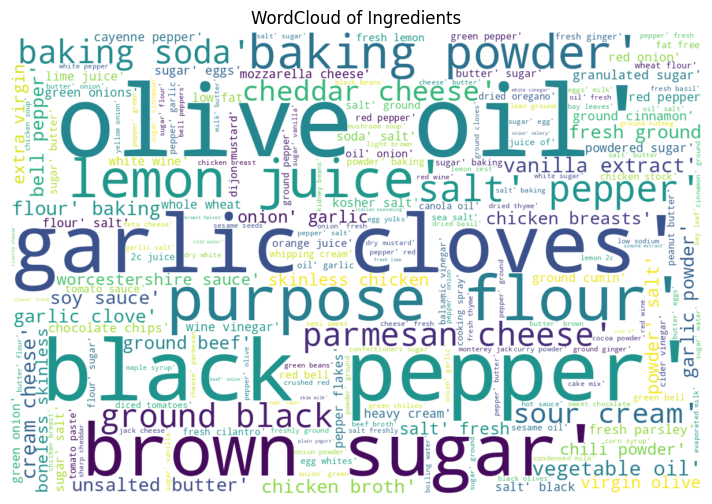

In [44]:
ingredients_text = " ".join(
    recipes_df.select(explode(split(col("ingredients"), ",")).alias("ingredient"))
              .na.drop()
              .rdd.map(lambda r: r["ingredient"].strip())
              .collect()
)

ing_wc = WordCloud(width=1200, height=800, background_color='white').generate(ingredients_text)
plt.figure(figsize=(10,6))
plt.imshow(ing_wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Ingredients")
plt.show()

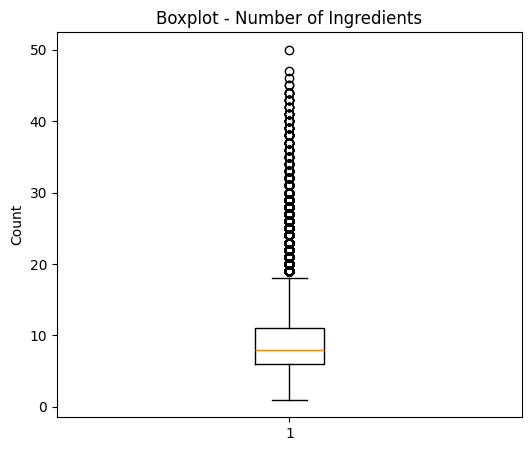

In [47]:
numeric_df = recipes_df.select("num_ingredients", "num_steps", "description_length").toPandas()

plt.figure(figsize=(6,5))
plt.boxplot(numeric_df["num_ingredients"].dropna())
plt.title("Boxplot - Number of Ingredients")
plt.ylabel("Count")
plt.show()

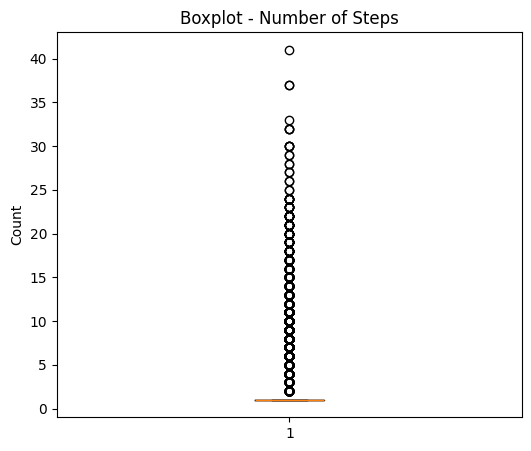

In [49]:
plt.figure(figsize=(6,5))
plt.boxplot(numeric_df["num_steps"].dropna())
plt.title("Boxplot - Number of Steps")
plt.ylabel("Count")
plt.show()

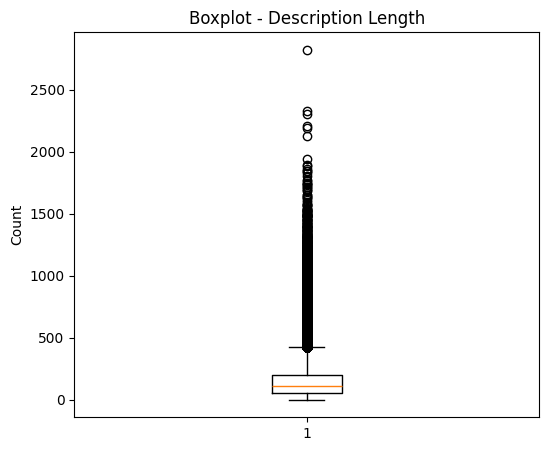

In [50]:
plt.figure(figsize=(6,5))
plt.boxplot(numeric_df["description_length"].dropna())
plt.title("Boxplot - Description Length")
plt.ylabel("Count")
plt.show()

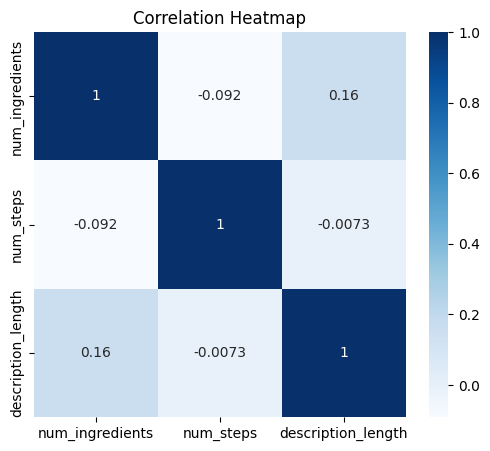

In [51]:
import seaborn as sns
plt.figure(figsize=(6,5))
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Correlation Heatmap")
plt.show()

/tmp/ipykernel_24955/724509216.py:5: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="tag", x="count", data=tags_pd, palette="coolwarm")


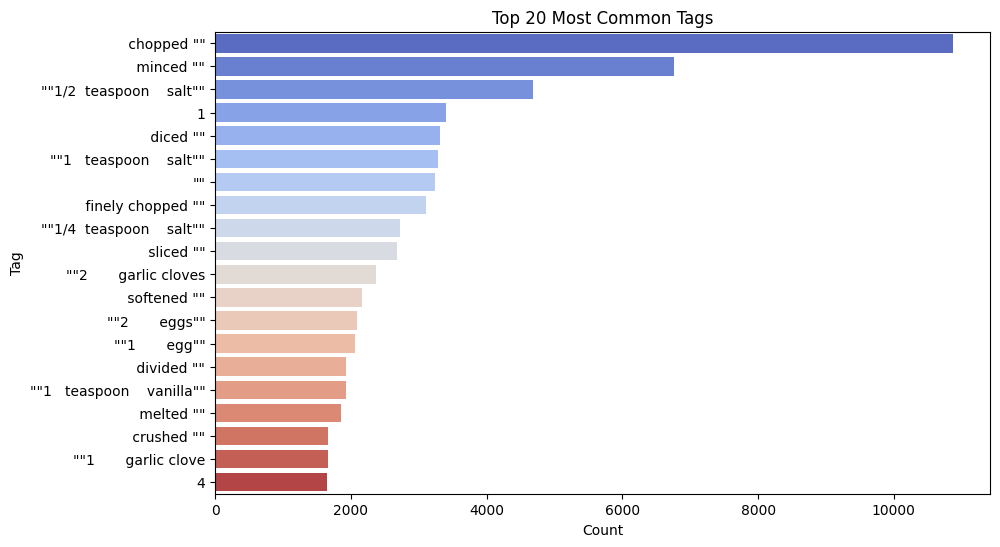

In [52]:
tags_df = recipes_df.select(explode(split(col("tags"), ",")).alias("tag"))
tags_count = tags_df.groupBy("tag").count().orderBy(col("count").desc()).limit(20)
tags_pd = tags_count.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(y="tag", x="count", data=tags_pd, palette="coolwarm")
plt.title("Top 20 Most Common Tags")
plt.xlabel("Count")
plt.ylabel("Tag")
plt.show()

/tmp/ipykernel_24955/2169018662.py:5: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="ingredient", x="count", data=ingredients_pd, palette="viridis")


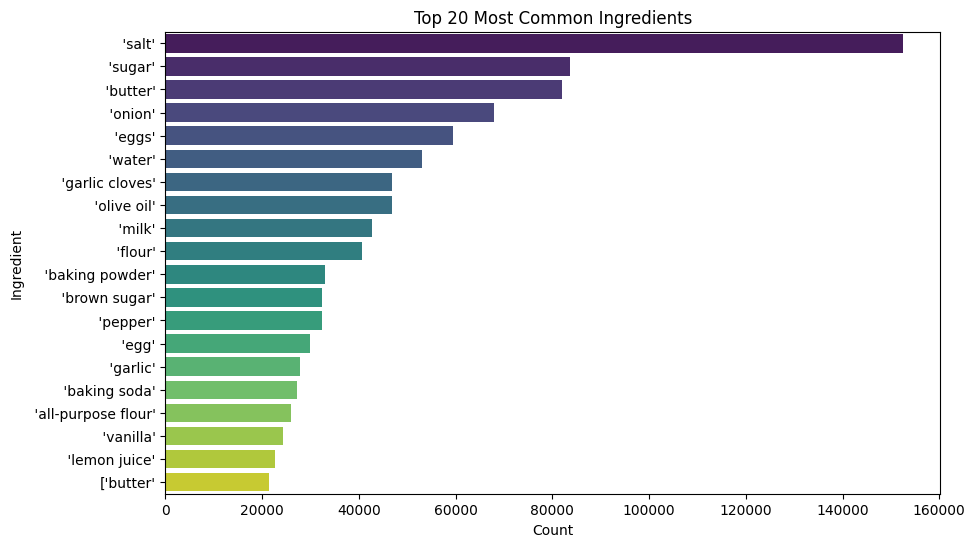

In [53]:
ingredients_df = recipes_df.select(explode(split(col("ingredients"), ",")).alias("ingredient"))
ingredients_count = ingredients_df.groupBy("ingredient").count().orderBy(col("count").desc()).limit(20)
ingredients_pd = ingredients_count.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(y="ingredient", x="count", data=ingredients_pd, palette="viridis")
plt.title("Top 20 Most Common Ingredients")
plt.xlabel("Count")
plt.ylabel("Ingredient")
plt.show()

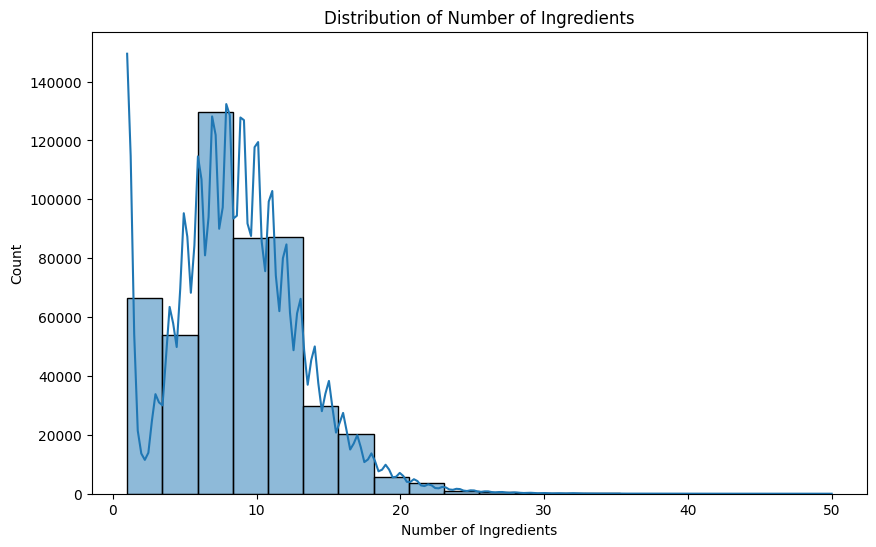

In [55]:
num_df = recipes_df.select("num_ingredients", "description_length", "num_steps").toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(num_df["num_ingredients"], bins=20, kde=True)
plt.title("Distribution of Number of Ingredients")
plt.xlabel("Number of Ingredients")
plt.show()

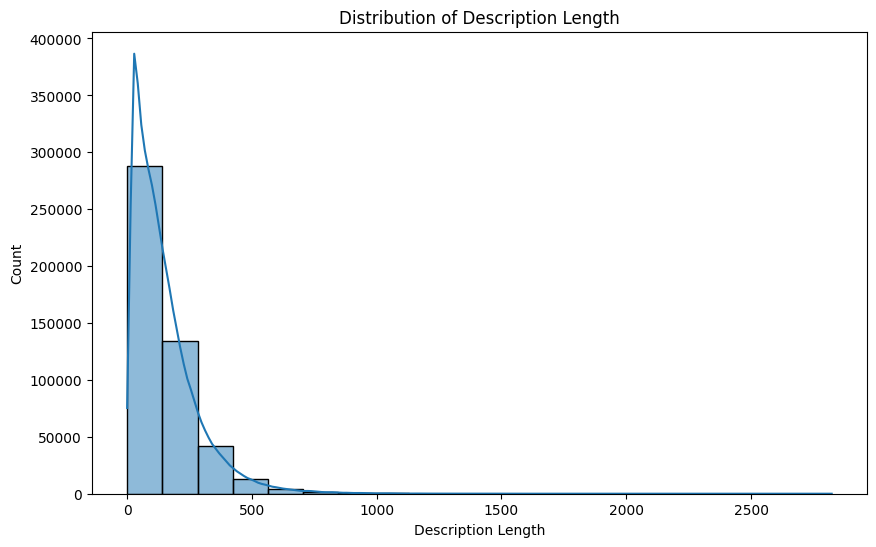

In [56]:
plt.figure(figsize=(10, 6))
sns.histplot(num_df["description_length"], bins=20, kde=True)
plt.title("Distribution of Description Length")
plt.xlabel("Description Length")
plt.show()

Text(0.5, 1.0, 'Ingredients vs Steps')

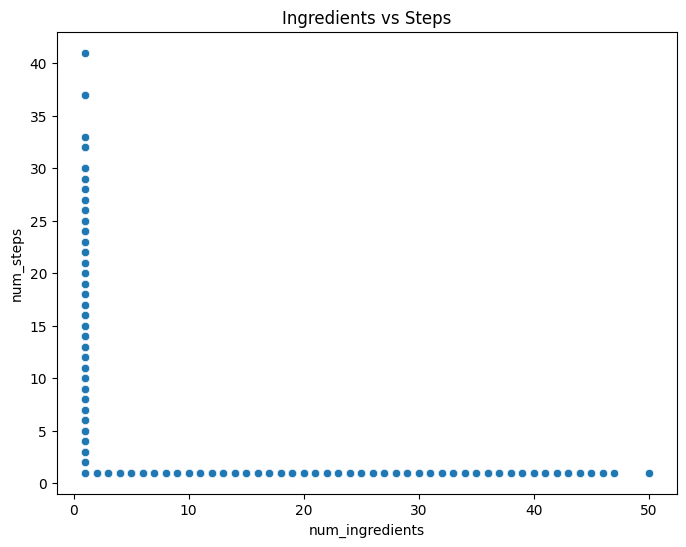

In [57]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="num_ingredients", y="num_steps", data=num_df)
plt.title("Ingredients vs Steps")

Text(0.5, 1.0, 'Description Length vs Number of Ingredients')

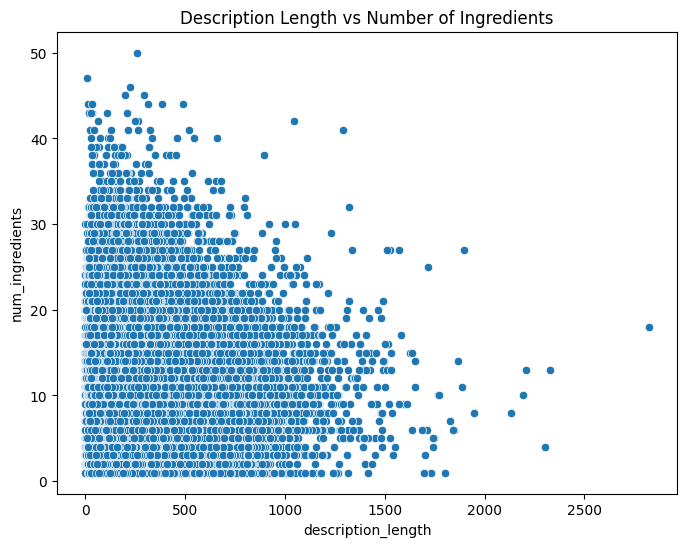

In [59]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="description_length", y="num_ingredients", data=num_df)
plt.title("Description Length vs Number of Ingredients")